In [1]:
%%sh
wget http://data.mxnet.io/data/caltech-256/caltech-256-60-train.rec
wget http://data.mxnet.io/data/caltech-256/caltech-256-60-val.rec

--2020-12-16 17:59:53--  http://data.mxnet.io/data/caltech-256/caltech-256-60-train.rec
Resolving data.mxnet.io (data.mxnet.io)... 74.125.193.121, 2a00:1450:400b:c01::79
Connecting to data.mxnet.io (data.mxnet.io)|74.125.193.121|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://data.mxnet.io.s3-website-us-west-1.amazonaws.com/data/caltech-256/caltech-256-60-train.rec [following]
--2020-12-16 17:59:53--  http://data.mxnet.io.s3-website-us-west-1.amazonaws.com/data/caltech-256/caltech-256-60-train.rec
Resolving data.mxnet.io.s3-website-us-west-1.amazonaws.com (data.mxnet.io.s3-website-us-west-1.amazonaws.com)... 52.219.116.19
Connecting to data.mxnet.io.s3-website-us-west-1.amazonaws.com (data.mxnet.io.s3-website-us-west-1.amazonaws.com)|52.219.116.19|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 363622688 (347M) [binary/octet-stream]
Saving to: ‘caltech-256-60-train.rec’

     0K .......... .......... .......... .

In [2]:
import boto3
import sagemaker

print(sagemaker.__version__)

session = sagemaker.Session()
bucket = session.default_bucket()

2.19.0


In [3]:
prefix = 'caltech256'

s3_train_path = session.upload_data(path='caltech-256-60-train.rec', bucket=bucket, key_prefix=prefix+'/input/train')
s3_val_path = session.upload_data(path='caltech-256-60-val.rec',   bucket=bucket, key_prefix=prefix+'/input/validation')
s3_output = 's3://{}/{}/output'.format(bucket, prefix)

print(s3_train_path)
print(s3_val_path)
print(s3_output)

s3://sagemaker-eu-west-1-613904931467/caltech256/input/train/caltech-256-60-train.rec
s3://sagemaker-eu-west-1-613904931467/caltech256/input/validation/caltech-256-60-val.rec
s3://sagemaker-eu-west-1-613904931467/caltech256/output


### Get the name of the image classification algorithm in our region

In [4]:
from sagemaker import image_uris

region = boto3.Session().region_name    
container = image_uris.retrieve('image-classification', region)
print(container)

685385470294.dkr.ecr.eu-west-1.amazonaws.com/image-classification:1


### Configure the training job

In [5]:
role = sagemaker.get_execution_role()

ic = sagemaker.estimator.Estimator(container,
                                   role, 
                                   instance_count=1, 
                                   instance_type='ml.p3.2xlarge',
                                   output_path=s3_output)

### Set algorithm parameters

In [6]:
ic.set_hyperparameters(num_layers=50,               # Train a Resnet-18 model
                       use_pretrained_model=1,      # Train from scratch
                       num_classes=257,             # 256 classes + 1 clutter class
                       num_training_samples=15240,  # Number of training samples
                       learning_rate=0.001,
                       epochs=10)                    # Learn the training samples 2 times

### Set dataset parameters

In [7]:
train_data = sagemaker.TrainingInput(s3_train_path, 
                                        distribution='FullyReplicated', 
                                        content_type='application/x-recordio',
                                        s3_data_type='S3Prefix')

validation_data = sagemaker.TrainingInput(s3_val_path,
                                             distribution='FullyReplicated', 
                                             content_type='application/x-recordio', 
                                             s3_data_type='S3Prefix')

s3_channels = {'train': train_data, 'validation': validation_data}

### Train the model

In [ ]:
ic.fit(inputs=s3_channels)

2020-12-16 18:01:12 Starting - Starting the training job...
2020-12-16 18:01:36 Starting - Launching requested ML instancesProfilerReport-1608141672: InProgress
......
2020-12-16 18:02:36 Starting - Preparing the instances for training.......
2020-12-16 18:04:11 Downloading - Downloading input data
2020-12-16 18:04:11 Training - Downloading the training image......
2020-12-16 18:04:58 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
[12/16/2020 18:04:59 INFO 139684286744384] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/image_classification/default-input.json: {u'beta_1': 0.9, u'gamma': 0.9, u'beta_2': 0.999, u'optimizer': u'sgd', u'use_pretrained_model': 0, u'eps': 1e-08, u'epochs': 30, u'lr_scheduler_factor': 0.1, u'num_layers': 152, u'image_shape': u'3,224,224', u'precision_dtype': u'float32', u'mini_batch_size': 32, u'weight_decay': 0.0001, u'learning_rate': 0.1, u'momentum': 0}
[12/16/2

[12/16/2020 18:06:32 INFO 139684286744384] Epoch[1] Batch [160]#011Speed: 300.554 samples/sec#011accuracy=0.755047
[12/16/2020 18:06:34 INFO 139684286744384] Epoch[1] Batch [180]#011Speed: 300.604 samples/sec#011accuracy=0.759669
[12/16/2020 18:06:36 INFO 139684286744384] Epoch[1] Batch [200]#011Speed: 300.578 samples/sec#011accuracy=0.762904
[12/16/2020 18:06:39 INFO 139684286744384] Epoch[1] Batch [220]#011Speed: 300.613 samples/sec#011accuracy=0.764847
[12/16/2020 18:06:41 INFO 139684286744384] Epoch[1] Batch [240]#011Speed: 300.640 samples/sec#011accuracy=0.767765
[12/16/2020 18:06:43 INFO 139684286744384] Epoch[1] Batch [260]#011Speed: 300.741 samples/sec#011accuracy=0.769157
[12/16/2020 18:06:45 INFO 139684286744384] Epoch[1] Batch [280]#011Speed: 300.774 samples/sec#011accuracy=0.771130
[12/16/2020 18:06:47 INFO 139684286744384] Epoch[1] Batch [300]#011Speed: 300.778 samples/sec#011accuracy=0.773983
[12/16/2020 18:06:49 INFO 139684286744384] Epoch[1] Batch [320]#011Speed: 300.83

[12/16/2020 18:09:15 INFO 139684286744384] Epoch[3] Batch [420]#011Speed: 300.964 samples/sec#011accuracy=0.950193
[12/16/2020 18:09:17 INFO 139684286744384] Epoch[3] Batch [440]#011Speed: 300.980 samples/sec#011accuracy=0.950255
[12/16/2020 18:09:19 INFO 139684286744384] Epoch[3] Batch [460]#011Speed: 301.036 samples/sec#011accuracy=0.951464
[12/16/2020 18:09:20 INFO 139684286744384] Epoch[3] Train-accuracy=0.951484
[12/16/2020 18:09:20 INFO 139684286744384] Epoch[3] Time cost=50.480
[12/16/2020 18:09:37 INFO 139684286744384] Epoch[3] Validation-accuracy=0.834276
[12/16/2020 18:09:37 INFO 139684286744384] Storing the best model with validation accuracy: 0.834276
[12/16/2020 18:09:37 INFO 139684286744384] Saved checkpoint to "/opt/ml/model/image-classification-0004.params"
[12/16/2020 18:09:39 INFO 139684286744384] Epoch[4] Batch [20]#011Speed: 295.005 samples/sec#011accuracy=0.976190
[12/16/2020 18:09:42 INFO 139684286744384] Epoch[4] Batch [40]#011Speed: 298.209 samples/sec#011accura

[12/16/2020 18:12:07 INFO 139684286744384] Epoch[6] Batch [140]#011Speed: 300.316 samples/sec#011accuracy=0.996676
[12/16/2020 18:12:09 INFO 139684286744384] Epoch[6] Batch [160]#011Speed: 300.452 samples/sec#011accuracy=0.997089
[12/16/2020 18:12:11 INFO 139684286744384] Epoch[6] Batch [180]#011Speed: 300.483 samples/sec#011accuracy=0.997238
[12/16/2020 18:12:13 INFO 139684286744384] Epoch[6] Batch [200]#011Speed: 300.517 samples/sec#011accuracy=0.997201
[12/16/2020 18:12:16 INFO 139684286744384] Epoch[6] Batch [220]#011Speed: 300.648 samples/sec#011accuracy=0.997313
[12/16/2020 18:12:18 INFO 139684286744384] Epoch[6] Batch [240]#011Speed: 300.649 samples/sec#011accuracy=0.997277
[12/16/2020 18:12:20 INFO 139684286744384] Epoch[6] Batch [260]#011Speed: 300.726 samples/sec#011accuracy=0.997486
[12/16/2020 18:12:22 INFO 139684286744384] Epoch[6] Batch [280]#011Speed: 300.761 samples/sec#011accuracy=0.997553
[12/16/2020 18:12:24 INFO 139684286744384] Epoch[6] Batch [300]#011Speed: 300.83

[12/16/2020 18:14:56 INFO 139684286744384] Epoch[8] Batch [460]#011Speed: 299.720 samples/sec#011accuracy=0.999593
[12/16/2020 18:14:57 INFO 139684286744384] Epoch[8] Train-accuracy=0.999606
[12/16/2020 18:14:57 INFO 139684286744384] Epoch[8] Time cost=50.698
[12/16/2020 18:15:14 INFO 139684286744384] Epoch[8] Validation-accuracy=0.836842
[12/16/2020 18:15:14 INFO 139684286744384] Storing the best model with validation accuracy: 0.836842
[12/16/2020 18:15:14 INFO 139684286744384] Saved checkpoint to "/opt/ml/model/image-classification-0009.params"
[12/16/2020 18:15:17 INFO 139684286744384] Epoch[9] Batch [20]#011Speed: 293.862 samples/sec#011accuracy=1.000000
[12/16/2020 18:15:19 INFO 139684286744384] Epoch[9] Batch [40]#011Speed: 297.104 samples/sec#011accuracy=1.000000
[12/16/2020 18:15:21 INFO 139684286744384] Epoch[9] Batch [60]#011Speed: 298.587 samples/sec#011accuracy=0.999488
[12/16/2020 18:15:23 INFO 139684286744384] Epoch[9] Batch [80]#011Speed: 298.945 samples/sec#011accuracy

### Deploy the model

In [ ]:
ic_predictor = ic.deploy(initial_instance_count=1,
                         instance_type='ml.t2.medium')

---------------------!

### Download a test image

--2020-12-16 18:27:35--  https://upload.wikimedia.org/wikipedia/commons/b/b7/LabradorWeaving.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 91.198.174.208, 2620:0:862:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|91.198.174.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 128484 (125K) [image/jpeg]
Saving to: ‘/tmp/test.jpg’

/tmp/test.jpg       100%[===================>] 125.47K  --.-KB/s    in 0.06s   

2020-12-16 18:27:35 (2.12 MB/s) - ‘/tmp/test.jpg’ saved [128484/128484]



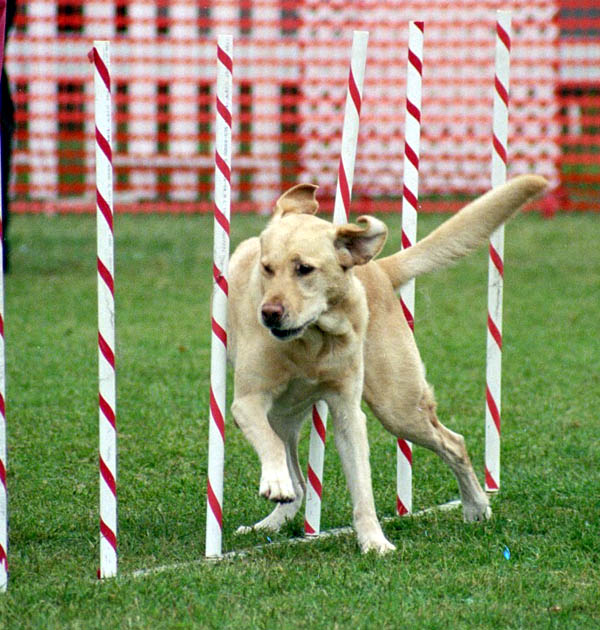

In [ ]:
# Dog
!wget -O /tmp/test.jpg https://upload.wikimedia.org/wikipedia/commons/b/b7/LabradorWeaving.jpg
file_name = '/tmp/test.jpg'
from IPython.display import Image
Image(file_name)

### Predict test image

In [14]:
import boto3, json
import numpy as np

runtime = boto3.Session().client(service_name='runtime.sagemaker')

with open(file_name, 'rb') as f:
    payload = f.read()
    payload = bytearray(payload)

response = runtime.invoke_endpoint(EndpointName=ic_predictor.endpoint_name, 
                                   ContentType='application/x-image', 
                                   Body=payload)

result = response['Body'].read()
result = json.loads(result)
index = np.argmax(result)
print(result[index], index)

# You should see class index 55, corresponding to the 56th class: 'dog'
# https://www.kaggle.com/jessicali9530/caltech256

0.8770086765289307 55


### Delete endpoint

In [ ]:
ic_predictor.delete_endpoint()